# Data Literacy
#### University of Tübingen, Winter Term 2021/22
## Exercise Sheet 3
&copy; 2021 Prof. Dr. Philipp Hennig & Nico Krämer & Emilia Magnani

This sheet is **due on Monday, November 15, 2021 at 10am sharp (i.e. before the start of the lecture).**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.special

import matplotlib.tri as tri


# For the docstrings / type hints
from typing import Union, Optional, Tuple

rng = np.random.default_rng(seed=1)

# Exercise 03
## Task 2.)

Given are iid samples from a uniform distribution $X_i,..,X_n ~ U(0,\theta)$.\n

## a.)
Likelihood of a single observation:
$$
p(X_i \mid \theta) = \frac{1}{\theta}
$$

Joint Likelihood:
$$ 
p(X \mid \theta) = \prod_{i = 1}^{n} \frac{1}{\theta}
$$
$$
log p(X \mid \theta) = log(\theta^{-n}) = -n * log(\theta)
$$

## b.)
Maximum Likelihood Estimator

$$ 
\frac{d}{dx} log p(X \mid \theta) = \frac{-n}{\theta}
$$
With $\theta > 239$

MLE: 
$$ 
\frac{-n}{\theta} = 0
$$
Maximizes for theta --> $\infty$. Based on given data, assumption for $\theta$:
$$
\theta_X = X_{max}+ \mu_{X} \pm std_{X} = 239 + 110.1 \pm 74.7 = 274 - 423
$$


## c.) Likelihood plot see below

In [36]:
X = np.array([101,1,93,78,239,185,65,202,12,125])
mean_x = np.mean(X)
std_x = np.std(X)
print(f"Mean {mean_x} and var {std_x}")
print(f"Assumption for Theta range +- (MLE): {239 + mean_x - std_x}/{239 + mean_x + std_x}")

Mean 110.1 and var 74.73881187174439
Assumption for Theta range +- (MLE): 274.36118812825566/423.8388118717444


In [45]:
n = 10 
def llhood_task2(n,thetamin,thetamax):
    theta = np.arange(thetamin,thetamax,1)
    log_llhood_t = np.zeros(len(theta))
    for i in range(len(log_llhood_t)):
        log_llhood_t[i] = -n/theta[i]
    llhood_t = np.exp(log_llhood_t)
    llhood_t_norm = llhood_t/llhood_t.sum()
    return llhood_t_norm, theta
theta, llhood_theta = llhood_task2(10,274,423)

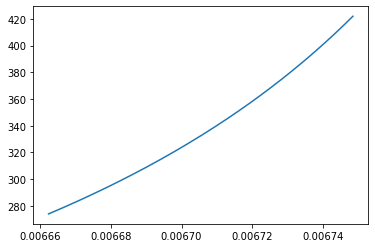

In [46]:
# Plot llhood
fig, axes = plt.subplots(1,1)
axes.plot(theta,llhood_theta)


---

## Data estimation
In this week we will look at maximum likelihood estimation for exit polls / election data.
We will work with the results from the German general election in September 2021.
The full data set can be downloaded from the "Bundeswahlleiter":
https://www.bundeswahlleiter.de/bundestagswahlen/2021/ergebnisse/opendata/csv/
(explained in https://www.bundeswahlleiter.de/bundestagswahlen/2021/ergebnisse/opendata.html#39734920-0eaf-4633-8858-ae792d5d610b).

For this task, we will only require a subset of this data, which has already been slimmed down by us (you're welcome) and provided as a csv file (see 'data_slim.csv').


**Task:** Load  the data 'data_slim.csv'.

In [2]:
data = pd.read_csv('data/data_slim.csv')
data.head()

Unnamed: 0 Gruppenname      Anzahl  Prozent
0           7         CDU   8775471.0     18.0
1           9         SPD  11955434.0     25.0
2          11         AfD   4803902.0     10.0
3          13         FDP   5319952.0     11.0
4          15   DIE LINKE   2270906.0      4.0

To better understand the concepts, we will start with considering a two-party setup (where we assume there are only two parties), and then extend the concepts to multiple parties.


**Task:**
Pick a party (please pick one of the larger ones, otherwise the results are meaningless), and aggregate the number of votes into "Party X" and "Not party X".    
Then, create a list of all votes. For example, if  you choose "Party X" = "SPD", and "SPD" has 3 votes, and all the others ("Not party X") have 4 votes, create the list
["SPD", "SPD","SPD", "others", "others", "others", "others"]. This will be useful for subsampling the exit poll below.



In [3]:
# Divide in two parties and create a list of votes
Gruene = data[data['Gruppenname'] == 'GRÜNE'].Anzahl
NotGruene = data[data['Gruppenname'] != 'GRÜNE'].Anzahl.sum()
votes = np.append(np.full(int(Gruene.values),'GRÜNE'),np.full(int(NotGruene),'Not GRÜNE'))
votes_list = votes.tolist()

## Exit polls

One common way of predicting election results is to conduct what is known as an exit poll.
An exit poll is a collection ("poll") of voters taken when they exit the polling stations. Exit polls are used to gain an early indication about the result of the elections.

In the next task we will use the German election data to simulate an exit poll.

**Task:** 
Write a function that subsamples $N$ votes from the aggregated voting results (with only two parties). If you prefer not to use the list created above for subsampling, feel free to be creative.


In [4]:
# Write here your simulated exit poll function
def sim_exit_poll(votings,N):
    """Subsampling randomly from the aggregated voting results"""
    return np.random.choice(votings,size=N,replace=False)

In [5]:
exit_poll = sim_exit_poll(votes_list,10)

In [6]:
exit_poll

array(['Not GRÜNE', 'Not GRÜNE', 'Not GRÜNE', 'GRÜNE', 'Not GRÜNE',
       'Not GRÜNE', 'Not GRÜNE', 'Not GRÜNE', 'Not GRÜNE', 'Not GRÜNE'],
      dtype='<U9')

Now, we will use the exit poll results to _infer_ the true election results.
The overarching question will be _how large does the exit poll have to be for the prediction to be significant_? 

To this end, compute the likelihood of observing a given exit poll $N = [N_p, N_{\backslash p}]$ under _a_ probability distribution $\pi = (\pi_p, \pi_{\backslash p})$ ("p" is your party).

The likelihood is
$$
p(N \mid \pi) = \prod_{i=1}^2 \pi_i^{N_i}.
$$


**Task:**
Turn the likelihood function above into a python function (consider using a *log*likelihood instead of a likelihood for numerical stability. Normalisation of log likelihoods can be done in a stable way with the log-sum-exp trick; e.g. https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.logsumexp.html )

In [7]:
from scipy.special import logsumexp

# MLE estimator 

The MLE estimator is calculated by: $ \frac{p(N \mid \pi)}{d\pi} $.

$$ log p(N \mid \pi) = {N_p}*log(\pi_p) + {N_{np}}*log(\pi_{np})$$

$$ \frac{log p(N \mid \pi)}{d\pi} = MLE = N_p * \frac{1}{\pi_p} + N_{np} * \frac{1}{\pi_{np}}, with $$
With:
$$ \pi_{np} = 1- \pi_p$$

In [8]:
# Likelihood function 
def likelihood(sample,categ,p):
    Ntemp = np.zeros(len(categ))
    for i in range(len(categ)):
        Ntemp[i] = len(sample[sample == categ[i]])
    llhood = (Ntemp*np.log(p)).sum()
    return llhood

**Task:**
Plot this likelihood function (as a function of $\pi$) for different values of $N$, and find the maximum likelihood estimator for $\pi$, for each choice of $N$. 

How large does $N$ have to be for the MLE to be close to the truth?

In [15]:
# Function: Compute likelihood dependent on N
def logllhood_N(votes_list,categ,start,stop,step):
    """p = 0:0.01:1"""
    N = np.arange(start,stop,step)
    p = np.arange(0.01,1,0.01)
    log_likelihood = np.zeros((len(p),len(N)))
    MLE = np.zeros(len(N))
    ind_N = 0
    for num in N:
        exit_poll_temp = sim_exit_poll(votes_list,num)
        log_likelihood_temp = np.zeros(len(p))
        i = 0
        for prob in p:
            log_likelihood_temp[i] = likelihood(exit_poll_temp,categ,[prob,1-prob])
            i += 1
        log_likelihood[:,ind_N] = log_likelihood_temp/logsumexp(log_likelihood_temp) # Normalize log likelihood
        ## Here the MLE is only derived by looking at the maximum! 
        MLE[ind_N] = p[np.where(log_likelihood_temp == np.max(log_likelihood_temp))]
        ind_N += 1
    return log_likelihood, MLE
    
likelihood_gruene, MLE_gruene = logllhood_N(votes_list,['GRÜNE','Not GRÜNE'],1,1500,100)

In [18]:
# Look at likelioods for N < 100
likelihood_gruene_small, MLE_gruene_small = logllhood_N(votes_list,['GRÜNE','Not GRÜNE'],1,100,10)

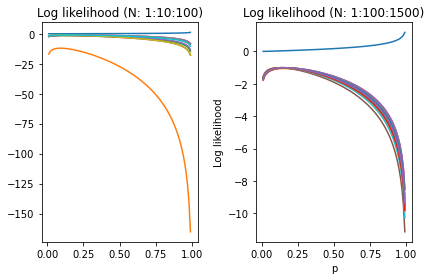

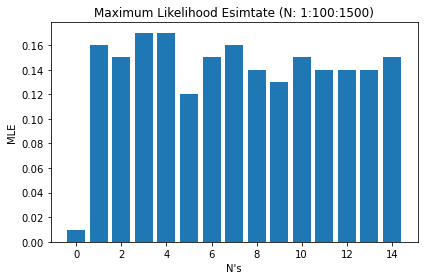

In [28]:
# Plot likelihood function for different values of N
p = np.arange(0.01,1,0.01)
fig, ax = plt.subplots(1,2)
for ind in range(likelihood_gruene.shape[1]):
    ax[1].plot(p,-likelihood_gruene[:,ind]) # Using negative log likelihood?

for ind2 in range(likelihood_gruene_small.shape[1]):
    ax[0].plot(p,-likelihood_gruene_small[:,ind2])

ax[1].set_title('Log likelihood (N: 1:100:1500)')
ax[1].set_ylabel('Log likelihood')
ax[1].set_xlabel('p')
ax[0].set_title('Log likelihood (N: 1:10:100)')
ax[1].set_ylabel('Log likelihood')
ax[1].set_xlabel('p')
plt.tight_layout()

# MLE
fig2, ax2 = plt.subplots(1,1)
ax2.bar(np.arange(len(MLE_gruene)),MLE_gruene)
ax2.set_title('Maximum Likelihood Esimtate (N: 1:100:1500)')
ax2.set_ylabel('MLE')
ax2.set_xlabel("N's")
plt.tight_layout()


## Predicting wins and losses


The exit poll subsampling strategy can be used to predict the probabilities of a party winning an election, or exceeding a certain threshold of vote shares.


**Task:** Plot the probability of the vote shares of DIE LINKE exceeding $\tau = 0.1$ as a function of the exit poll size $N$. Do the same for SPD and threshold $\tau=0.2$. What value of $N$ seems sufficient to predict the actual outcomes?


In [17]:
# Plot for DIE LINKE 
threshold = 0.1
LINKE = data[data['Gruppenname'] == 'DIE LINKE'].Anzahl
NotLINKE = data[data['Gruppenname'] != 'DIE LINKE'].Anzahl.sum()
votes_LINKE = np.append(np.full(int(LINKE.values),'LINKE'),np.full(int(NotLINKE),'Not LINKE'))
votes_LINKE_list = votes_LINKE.tolist()
llhood_LINKE, MLP_LINKE = logllhood_N(votes_LINKE_list,['LINKE','Not LINKE'],1,200,100)
    

In [ ]:
# Plot for SPD 
threshold = 0.2





# Multiple parties

Here we generalise the reasoning from above to more than two parties (actually, three). For plotting we will use a 3-simplex (see below).

**Task:** Pick two parties, and  split the dataset into Party 1, Party 2 and "others". You may use the `aggregate()` function below.

In [ ]:
def aggregate(
    my_party1: str, my_party2: str, data: pd.DataFrame
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Aggregate the counts of two parties in the election data set.
    
    Parameters
    ----------
    my_party1
        String describing a party.
    my_party2
        String describing a party.
    data
        Election data to be aggregated from.
    
    Returns
    -------
    votes_all
        Aggregated list of votes ["P1", ..., "P1", "P2", ..., "P2", "others", ..., "others"]
    parties_all
        List of strings, describing the two parties and "others"
    truth
        True distribution of votes (as percentages) in the aggregated list of election results.
    """
    result_my_party1 = int(data[data["Gruppenname"] == my_party1]["Anzahl"].sum())
    result_my_party2 = int(data[data["Gruppenname"] == my_party2]["Anzahl"].sum())
    result_others = int(
        data[
            np.logical_and(
                data["Gruppenname"] != my_party1, data["Gruppenname"] != my_party2
            )
        ]["Anzahl"].sum()
    )

    truth = np.array([result_my_party1, result_my_party2, result_others]) / (
        result_my_party1 + result_my_party2 + result_others
    )
    votes_all = np.concatenate(
        (
            np.tile(my_party2, result_my_party2),
            np.tile(my_party1, result_my_party1),
            np.tile("others", result_others),
        )
    )
    parties_all = np.array([my_party1, my_party2, "others"])
    return votes_all, parties_all, truth

my_party1, my_party2 = "GRÜNE", "SPD"
votes_all, parties_all, truth = aggregate(my_party1, my_party2, data)

The code below defines a triangulation, and provides functions which transform Cartesian to Barycentric ("Simplex") coordinates. You can use this code for the next task ( so there is nothing for you to change here).

In [ ]:
# Define the triangle
corners = np.array([[0, 0], [1, 0], [0.5, 0.75 ** 0.5]])

# Mid-points of triangle sides opposite of each corner
midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 for i in range(3)]

triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=8)


def cartesian_to_barycentric(
    xy: np.ndarray,
    corners: np.ndarray,
    midpoints: np.ndarray,
    tol: Optional[float] = 1.0e-3,
) -> np.ndarray:
    """Converts Cartesian coordinates to Barycentric.
    
    Parameters
    ----------
    xy
        Cartesian coordinates. Array of shape (2,).
    corners
        Corners of the triangles. Array of shape (3,2).
    midpoints
        Midpoints of the triangles. Array of shape (3,2).
    tol
        A small value that describes when to clip values really close to 0 or 1.
    
    Returns
    -------
    Barycentric coordinate representation of the Cartesian coordinates. Array of shape (3,).
    """
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)


def barycentric_to_cartesian(bc: np.ndarray, corners: np.ndarray) -> np.ndarray:
    """Converts Barycentric coordinates to Cartesian coordinates.
    
    Parameters
    ----------
    bc
        Barycentric coordinates. Array of shape (3,).
    corners
        Corners of the triangles. Array of shape (3,2).
    
    Returns
    -------
    Cartesian coordinate representation of the Barycentric coordinates. Array of shape (2,).
    """
    return bc @ corners

As above, we will plot the likelihood function (as a function of $\pi$ ) for different values of $N$. In the simplex plot below, each coordinate represents a vote share distribution between party 1, party 2, and "others" (In fact here $\pi$ is a probability distribution $\pi = (\pi_\text{party1}, \pi_\text{party2}, \pi_\text{others})$). 

**Task:** 
Replace the placeholder contour lines below with the probability of observing the exit poll given the distribution implied by the coordinates. Also, compute the MLE and plot it next to the true distribution of vote shares/portions/... .


In [ ]:
p_space = np.stack([cartesian_to_barycentric(p, corners=corners, midpoints=midpoints) for p in zip(trimesh.x, trimesh.y)])
fig, axes = plt.subplots(
    ncols=3, figsize=(12, 3), dpi=300, sharex=True, sharey=True, constrained_layout=True
)

truth_in_simplex = barycentric_to_cartesian(truth, corners=corners)
for poll_size, axis in zip([5, 50, 500], axes):

    # Placeholder
    # Replace the uniform random numbers with likelihoods below
    axis.tricontourf(trimesh, rng.uniform(size=len(trimesh.x)), cmap="plasma", alpha=0.75)
    # Include the actual MLE and the actual truth here: the numbers below are placeholders
    axis.scatter(0.4, 0.6, marker="x", s=100, color="k", linewidth=2, label="MLE")
    axis.scatter(0.5, 0.5, marker=",", s=6, color="tab:cyan", label="TRUTH")

    
    axis.set_title(f"Poll size $N={poll_size}$")

    axis.annotate(my_party1, (-0.1, -0.1))
    axis.annotate(my_party2, (0.96, -0.1))
    axis.annotate("OTHERS", (0.5 - 0.075, 0.75 ** 0.5 + 0.05))

    axis.set_xlim((-0.2, 1.1))
    axis.set_ylim((-0.2, 1.1))

    axis.set_xticks(())
    axis.set_yticks(())
    axis.legend()

for axis in axes:
    axis.spines["right"].set_visible(False)
    axis.spines["top"].set_visible(False)
    axis.spines["bottom"].set_visible(False)
    axis.spines["left"].set_visible(False)


plt.show()

Based on these results, think about what size N you would use for your exit poll, if your goal was to identify the voting shares of all parties to, say, within the nearest percentage point. (You do not need to provide an answer in this sheet, this topic will be discussed in subsequent lectures).